In [15]:
import pandas as pd
import numpy as np
import pickle

from typing import List
from fastapi import FastAPI
# from schema import PostGet
from sqlalchemy import create_engine
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, RocCurveDisplay
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
SEED = 42

In [16]:
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

user_data_df = pd.read_sql(
    """SELECT * FROM user_data """,
    con=engine
)

post_text_df = pd.read_sql(
    """SELECT * FROM post_text_df """,
    con=engine
)

feed_data_df = pd.read_sql(
    """SELECT * FROM feed_data LIMIT 6500000 """,
    con=engine
)

In [17]:
print(user_data_df.head())
print(post_text_df.head())
print(feed_data_df.head())

   user_id  gender  age country               city  exp_group       os source
0      200       1   34  Russia          Degtyarsk          3  Android    ads
1      201       0   37  Russia             Abakan          0  Android    ads
2      202       1   17  Russia           Smolensk          4  Android    ads
3      203       0   18  Russia             Moscow          1      iOS    ads
4      204       0   36  Russia  Anzhero-Sudzhensk          3  Android    ads
   post_id                                               text     topic
0        1  UK economy facing major risks\n\nThe UK manufa...  business
1        2  Aids and climate top Davos agenda\n\nClimate c...  business
2        3  Asian quake hits European shares\n\nShares in ...  business
3        4  India power shares jump on debut\n\nShares in ...  business
4        5  Lacroix label bought by US firm\n\nLuxury good...  business
            timestamp  user_id  post_id action  target
0 2021-11-20 18:59:37    38327     5542   vie

In [18]:
feed_data_df = feed_data_df.loc[feed_data_df['action'] != 'like']

In [19]:
feed_data_df = feed_data_df.drop(['action'], axis=1)

In [20]:
df = feed_data_df.join(post_text_df.set_index('post_id'), on='post_id')

In [21]:
df = df.join(user_data_df.set_index('user_id'), on='user_id')

In [22]:
df = df.drop('text', axis=1)

In [23]:
df['ts'] = df[['timestamp']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df = df.drop('timestamp', axis = 1)
df.rename(columns = ({'ts':'timestamp'}), inplace = True)
df.sort_values(by='timestamp', inplace=True)

In [24]:
df.head()

,user_id,post_id,target,topic,gender,age,country,city,exp_group,os,source,timestamp
4706907,6357,6218,0,movie,1,24,Russia,Kirishi,3,Android,ads,1633068325
6027557,120291,4939,0,movie,0,29,Russia,Moscow,4,iOS,organic,1633068325
3119962,91774,5961,0,movie,1,18,Russia,Moscow,3,Android,ads,1633068325
4436366,146517,733,0,entertainment,1,26,Russia,Moscow,0,Android,organic,1633068405
1486229,5379,4629,0,movie,0,16,Russia,Barabinsk,3,iOS,ads,1633068405


In [25]:
df = df.reset_index()
df = df.drop('index', axis=1)
df.head()

,user_id,post_id,target,topic,gender,age,country,city,exp_group,os,source,timestamp
0,6357,6218,0,movie,1,24,Russia,Kirishi,3,Android,ads,1633068325
1,120291,4939,0,movie,0,29,Russia,Moscow,4,iOS,organic,1633068325
2,91774,5961,0,movie,1,18,Russia,Moscow,3,Android,ads,1633068325
3,146517,733,0,entertainment,1,26,Russia,Moscow,0,Android,organic,1633068405
4,5379,4629,0,movie,0,16,Russia,Barabinsk,3,iOS,ads,1633068405


In [26]:
train = df.iloc[:int(df.shape[0] * 4/5)].copy()
test = df.iloc[int(df.shape[0] * 4/5):].copy()

In [27]:
# train[mte_columns] = TargetEncoder().fit_transform(train[mte_columns], train['target'])

# train[num_columns] = StandardScaler().fit_transform(train[num_columns])
# test[num_columns] = StandardScaler().fit_transform(test[num_columns])

In [28]:
train

,user_id,post_id,target,topic,gender,age,country,city,exp_group,os,source,timestamp
0,6357,6218,0,movie,1,24,Russia,Kirishi,3,Android,ads,1633068325
1,120291,4939,0,movie,0,29,Russia,Moscow,4,iOS,organic,1633068325
2,91774,5961,0,movie,1,18,Russia,Moscow,3,Android,ads,1633068325
3,146517,733,0,entertainment,1,26,Russia,Moscow,0,Android,organic,1633068405
4,5379,4629,0,movie,0,16,Russia,Barabinsk,3,iOS,ads,1633068405
...,...,...,...,...,...,...,...,...,...,...,...,...
4643750,125526,5321,0,movie,1,16,Russia,Moscow,3,Android,organic,1639257066
4643751,6519,162,0,business,0,29,Russia,Lipetsk,4,iOS,ads,1639257077
4643752,91936,1220,0,politics,1,18,Russia,Engels,2,Android,ads,1639257077
4643753,5832,154,1,business,0,37,Russia,Saint Petersburg,3,iOS,ads,1639257079


In [29]:
X_train = train.drop(['target'],  axis = 1)
X_test = test.drop(['target'],  axis = 1)

y_train = train['target']
y_test = test['target']

In [30]:
# obj_columns = df.loc[:, df.dtypes == object].columns

# ohe_columns = [col for col in obj_columns if df[col].nunique() < 20]
# num_columns = list(df.select_dtypes(exclude='object').columns)

# ohe_columns_idx = [list(df.columns).index(col) for col in ohe_columns]
# mte_columns_idx = [list(df.columns).index(col) for col in mte_columns]
# num_columns_idx = [list(df.columns).index(col) for col in num_columns]

In [31]:
for col in ['topic', 'country', 'exp_group', 'os', 'source']:
    one_hot_train = pd.get_dummies(X_train[col], prefix=col, drop_first=True)
    X_train = pd.concat((X_train.drop(col, axis=1), one_hot_train), axis=1)
    one_hot_test = pd.get_dummies(X_test[col], prefix=col, drop_first=True)
    X_test = pd.concat((X_test.drop(col, axis=1), one_hot_test), axis=1)

In [32]:
X_train['city'] = LabelEncoder().fit_transform(X_train['city'])
X_test['city'] = LabelEncoder().fit_transform(X_test['city'])

In [33]:
print(f'Train class 1: {len(y_train[y_train == 1])}')
print(f'Train class 0: {len(y_train[y_train == 0])}')
print(f'Test class 1: {len(y_test[y_test == 1])}')
print(f'Test class 0: {len(y_test[y_test == 0])}')

Train class 1: 535488
Train class 0: 4108267
Test class 1: 159819
Test class 0: 1001120


In [34]:
def func_predictive(y_test, X_test, model):
    roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    auc(fpr, tpr)

Learning rate set to 0.379042
0:	learn: 0.6806017	total: 698ms	remaining: 11m 37s
100:	learn: 0.6460076	total: 42.4s	remaining: 6m 17s
200:	learn: 0.6428697	total: 1m 25s	remaining: 5m 38s
300:	learn: 0.6408447	total: 2m 12s	remaining: 5m 7s
400:	learn: 0.6392528	total: 2m 58s	remaining: 4m 27s
500:	learn: 0.6378761	total: 3m 51s	remaining: 3m 50s
600:	learn: 0.6366984	total: 4m 44s	remaining: 3m 8s
700:	learn: 0.6356068	total: 5m 37s	remaining: 2m 24s
800:	learn: 0.6345730	total: 6m 31s	remaining: 1m 37s
900:	learn: 0.6335488	total: 7m 25s	remaining: 49s
999:	learn: 0.6326044	total: 8m 22s	remaining: 0us


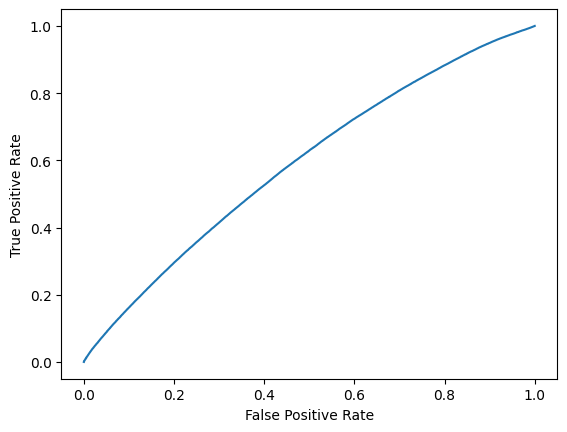

In [35]:
catboost = CatBoostClassifier(verbose=100, random_seed=SEED, scale_pos_weight=round((y_test == 0).sum()/(y_test == 1).sum(), 3))

catboost.fit(X_train, y_train)

func_predictive(y_test=y_test, X_test=X_test, model=catboost)

In [36]:
catboost.save_model('catboost', format="cbm")

In [37]:
users_posts = pd.read_sql(
    """
    SELECT DISTINCT ON (user_id) user_id, post_id
    FROM "feed_data"
    """,
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml")

In [38]:
nfrv_nikita_features_lesson_22 = users_posts.join(post_text_df.set_index('post_id'), on='post_id')
nfrv_nikita_features_lesson_22 = nfrv_nikita_features_lesson_22.join(user_data_df.set_index('user_id'), on='user_id')

In [39]:
nfrv_nikita_features_lesson_22.head()

,user_id,post_id,text,topic,gender,age,country,city,exp_group,os,source
0,200,2246,Games help you learn and play\n\nGod games in ...,tech,1,34,Russia,Degtyarsk,3,Android,ads
1,201,2339,Day 234: #365daysofgraterfulness i did a lot o...,covid,0,37,Russia,Abakan,0,Android,ads
2,202,6927,I just wanna say that amongst all the so-calle...,movie,1,17,Russia,Smolensk,4,Android,ads
3,203,1760,Mourinho takes swipe at Arsenal\n\nChelsea bos...,sport,0,18,Russia,Moscow,1,iOS,ads
4,204,5387,"This movie, with all its complexity and subtle...",movie,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [40]:
nfrv_nikita_features_lesson_22 = nfrv_nikita_features_lesson_22.drop('text', axis=1)

In [41]:
for col in ['country', 'exp_group', 'os', 'source', 'topic']:
    one_hot = pd.get_dummies(nfrv_nikita_features_lesson_22[col], prefix=col, drop_first=True)
    nfrv_nikita_features_lesson_22 = pd.concat((nfrv_nikita_features_lesson_22.drop(col, axis=1), one_hot), axis=1)


nfrv_nikita_features_lesson_22['city'] = LabelEncoder().fit_transform(nfrv_nikita_features_lesson_22['city'])

In [42]:
feature_en_df = nfrv_nikita_features_lesson_22.set_index(['user_id', 'post_id'])

In [43]:
feature_en_df.head()

,,gender,age,city,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,...,exp_group_3,exp_group_4,os_iOS,source_organic,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
200,2246,1,34,651,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
201,2339,0,37,2,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
202,6927,1,17,2931,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
203,1760,0,18,1953,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
204,5387,0,36,125,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


In [44]:
feature_en_df.shape

(163205, 25)

In [46]:
feature_en_df.to_sql('nfrv_nikita_features_lesson_22', con=engine, if_exists='replace')

205

In [ ]:
df = pd.read_sql(
    'SELECT * FROM nfrv_nikita_features_lesson_22', 
    con=engine
    )

In [ ]:
df.head()

,user_id,post_id,gender,age,city,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,...,exp_group_3,exp_group_4,os_iOS,source_organic,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,200,167,1,34,651,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,201,4368,0,37,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,202,6927,1,17,2931,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,203,1760,0,18,1953,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,204,5387,0,36,125,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
df.shape

(163205, 27)

In [13]:
import os
import pickle
from typing import List
from fastapi import FastAPI
from schema import PostGet
from datetime import datetime
import pandas as pd
from catboost import CatBoostClassifier
from sqlalchemy import create_engine

engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml")


def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":
        MODEL_PATH = '/workdir/user_input/model'
    else:
        MODEL_PATH = path
    return MODEL_PATH


def load_models():
    model_path = get_model_path("/my/super/path")
    from_file = CatBoostClassifier()
    model = from_file.load_model(model_path)
    return model


def batch_load_sql(query: str) -> pd.DataFrame:
    chunksize = 200000
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=chunksize):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)


def load_features() -> pd.DataFrame:
    df = pd.read_sql(
        "SELECT * FROM nfrv_nikita_features_lesson_22", 
        con=engine
        )
    return df


app = FastAPI()

model = load_models()
load_features = load_features()
post_text_df = pd.read_sql(
        "SELECT * FROM public.post_text_df",
        con=engine
        )


@app.get("/post/recommendations/", response_model=List[PostGet])
def recommended_posts(id: int, time: datetime, limit: int = 5) -> List[PostGet]:
    df_predict = pd.DataFrame({
        'post_id': post_text_df['post_id'], 
        'user_id': id
        })

    df_with_user_features = load_features.drop(['post_id', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics',
                                                'topic_sport', 'topic_tech'], axis=1)
    df_with_post_features = post_text_df[['topic', 'post_id']]
    
    for col in ['topic']:
        one_hot = pd.get_dummies(df_with_post_features[col], prefix=col, drop_first=True)
        df_with_post_features = pd.concat((df_with_post_features.drop(col, axis=1), one_hot), axis=1)

    df_predict = df_predict.merge(df_with_user_features, on='user_id', how='left')
    df_predict = df_predict.merge(df_with_post_features, on='post_id', how='left')

    prediction = model.predict_proba(df_predict)[:, 1]

    df_predict['prediction'] = prediction
    df_predict = df_predict.merge(post_text_df, on='post_id', how='left')

    df_predict = df_predict.sort_values(by='prediction', ascending=False).reset_index(drop=True)

    df_predict = df_predict.loc[:limit - 1]

    return [PostGet(**{
        'id': post_id,
        'text': df_predict[df_predict['post_id'] == post_id]['text'].values[0],
        'topic': df_predict[df_predict['post_id'] == post_id]['topic'].values[0]
    }) for post_id in df_predict['post_id']]

ImportError: cannot import name 'PostGet' from 'schema' (/Users/nv.anufriev/Library/Python/3.9/lib/python/site-packages/schema.py)